In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r'https://raw.githubusercontent.com/codebasics/nlp-tutorials/main/16_word_vectors_gensim_text_classification/fake_and_real_news.csv')

df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [3]:
df.isnull().any()

Text     False
label    False
dtype: bool

In [5]:
df.label.value_counts()

Fake    5000
Real    4900
Name: label, dtype: int64

In [6]:
import gensim.downloader as api
wv = api.load("word2vec-google-news-300")

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['label_num'] = encoder.fit_transform(df['label'])

In [8]:
df.head()

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


In [9]:
import spacy
nlp = spacy.load("en_core_web_lg")


In [15]:
def preprocess_and_vectorize(text):
    doc = nlp(text)
    final = []
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        final.append(token.lemma_)
        
    return wv.get_mean_vector(final)

In [16]:
df['vectors'] = df['Text'].apply(lambda x: preprocess_and_vectorize(x))

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.vectors, df.label_num, test_size=0.2)

In [24]:
X_train.shape, X_test.shape

((7920,), (1980,))

In [25]:
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

X_train_2d.shape, X_test_2d.shape

((7920, 300), (1980, 300))

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

clf = GradientBoostingClassifier()

clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1052
           1       0.98      0.98      0.98       928

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



In [33]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train_2d)
scaled_X_test = scaler.fit_transform(X_test_2d)


In [34]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()

clf.fit(scaled_X_train, y_train)

y_pred = clf.predict(scaled_X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1052
           1       0.91      0.95      0.93       928

    accuracy                           0.93      1980
   macro avg       0.93      0.93      0.93      1980
weighted avg       0.93      0.93      0.93      1980



Text(51.0, 0.5, 'Truth')

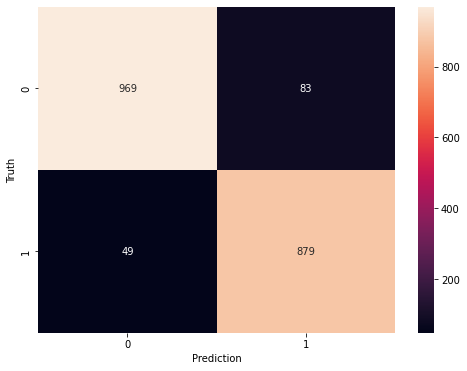

In [40]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Prediction")
plt.ylabel("Truth")

In [35]:
test_news = [
    "Michigan governor denies misleading U.S. House on Flint water (Reuters) - Michigan Governor Rick Snyder denied Thursday that he had misled a U.S. House of Representatives committee last year over testimony on Flintâ€™s water crisis after lawmakers asked if his testimony had been contradicted by a witness in a court hearing. The House Oversight and Government Reform Committee wrote Snyder earlier Thursday asking him about published reports that one of his aides, Harvey Hollins, testified in a court hearing last week in Michigan that he had notified Snyder of an outbreak of Legionnairesâ€™ disease linked to the Flint water crisis in December 2015, rather than 2016 as Snyder had testified. â€œMy testimony was truthful and I stand by it,â€ Snyder told the committee in a letter, adding that his office has provided tens of thousands of pages of records to the committee and would continue to cooperate fully.  Last week, prosecutors in Michigan said Dr. Eden Wells, the stateâ€™s chief medical executive who already faced lesser charges, would become the sixth current or former official to face involuntary manslaughter charges in connection with the crisis. The charges stem from more than 80 cases of Legionnairesâ€™ disease and at least 12 deaths that were believed to be linked to the water in Flint after the city switched its source from Lake Huron to the Flint River in April 2014. Wells was among six current and former Michigan and Flint officials charged in June. The other five, including Michigan Health and Human Services Director Nick Lyon, were charged at the time with involuntary manslaughter",
    " WATCH: Fox News Host Loses Her Sh*t, Says Investigating Russia For Hacking Our Election Is Unpatriotic This woman is insane.In an incredibly disrespectful rant against President Obama and anyone else who supports investigating Russian interference in our election, Fox News host Jeanine Pirro said that anybody who is against Donald Trump is anti-American. Look, it s time to take sides,  she began.",
    " Sarah Palin Celebrates After White Man Who Pulled Gun On Black Protesters Goes Unpunished (VIDEO) Sarah Palin, one of the nigh-innumerable  deplorables  in Donald Trump s  basket,  almost outdid herself in terms of horribleness on Friday."
]

test_news_vectors = [preprocess_and_vectorize(i) for i in test_news]

clf.predict(test_news_vectors)


array([1, 0, 0])